# Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from multisensory import MAPClassifier, ClassicalTask, BalancedComodulationTask, DetectionTask
from scipy import stats
import pandas as pd

plt.style.use('./style_sheet.mplstyle')

# Load SNN data 
import torch
path = "C:/Users/ghosh/OneDrive/Desktop/snn_boundaries_data_3651b83e"
SNN_data = pd.read_pickle(path)

To do: 

# Hyperparameters

In [2]:
# Interest 
intr_archs = [2, 1]
intr_tasks = ['classical', 'detection_dense', 'detection_sparse', 'comod+']

# Tasks
tasks = [
    ClassicalTask(s=0.1),
    DetectionTask(pm=2 / 3, pe=0.3, pc=0.28, pn=1 / 3, pi=0.01),  # dense
    DetectionTask(pm=2 / 3, pe=0.057, pc=0.95, pn=1 / 3, pi=0.01),  # sparse
    BalancedComodulationTask(s=0.2),
]
task_labels = ["Cl", "Dd", "Ds", "Cm+"]

classifier_type = MAPClassifier

col = ["xkcd:muted blue", "xkcd:coral pink"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["xkcd:dusty blue", "xkcd:off white", "xkcd:dusty orange"]
)
cmap_values = (
    np.array([[89, 133, 172, 255], [255, 255, 227, 255], [239, 130, 57, 255]]) / 255
)

# Functions

In [3]:
def single_filter(data, key, value):
    if value is None:
        return data[key].isnull()
    else:
        return data[key] == value

def filter_data(data, v_params):
    data = data.copy()
    for key, value in v_params.items():
        if key in data.columns:
            if isinstance(value, list):
                filter = np.sum(
                    [single_filter(data, key, v) for v in value], axis=0
                ).astype(bool)
                data = data[filter]
            else:
                if value is None:
                    data = data[single_filter(data, key, value)]
                else:
                    data = data[single_filter(data, key, value)]

    return data

def log_odds_coords(task_prior, directions):
    trials = task_prior.generate_trials(directions.shape[0], directions.shape[1])
    trials.A = directions[:, :, 0].astype("int32")
    trials.V = directions[:, :, 1].astype("int32")

    coords = []
    for pairs in [False, True]:
        classifier = classifier_type(task_prior, pairs=pairs)
        results = classifier.test(trials)
        coords.append(results.evidence[:, 2] - results.evidence[:, 0])

    return coords

def mode_cols(decisions, cmap_values):
    mode, count = stats.mode(decisions)
    cmap_mode = np.ones((mode.shape[1], 4))
    cmap_v = cmap_values[[0, 2], :] if mode.max() == 1 else np.copy(cmap_values)

    for d in range(mode.max() + 1):
        cmap_mode[mode[0] == d] = cmap_v[d]

    cmap_mode[:, -1] = (count - 3) / (decisions.shape[0] - 3)
    return cmap_mode

# Analysis

C:\Users\ghosh\AppData\Local\Temp\ipykernel_22664\1180741348.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, count = stats.mode(decisions)


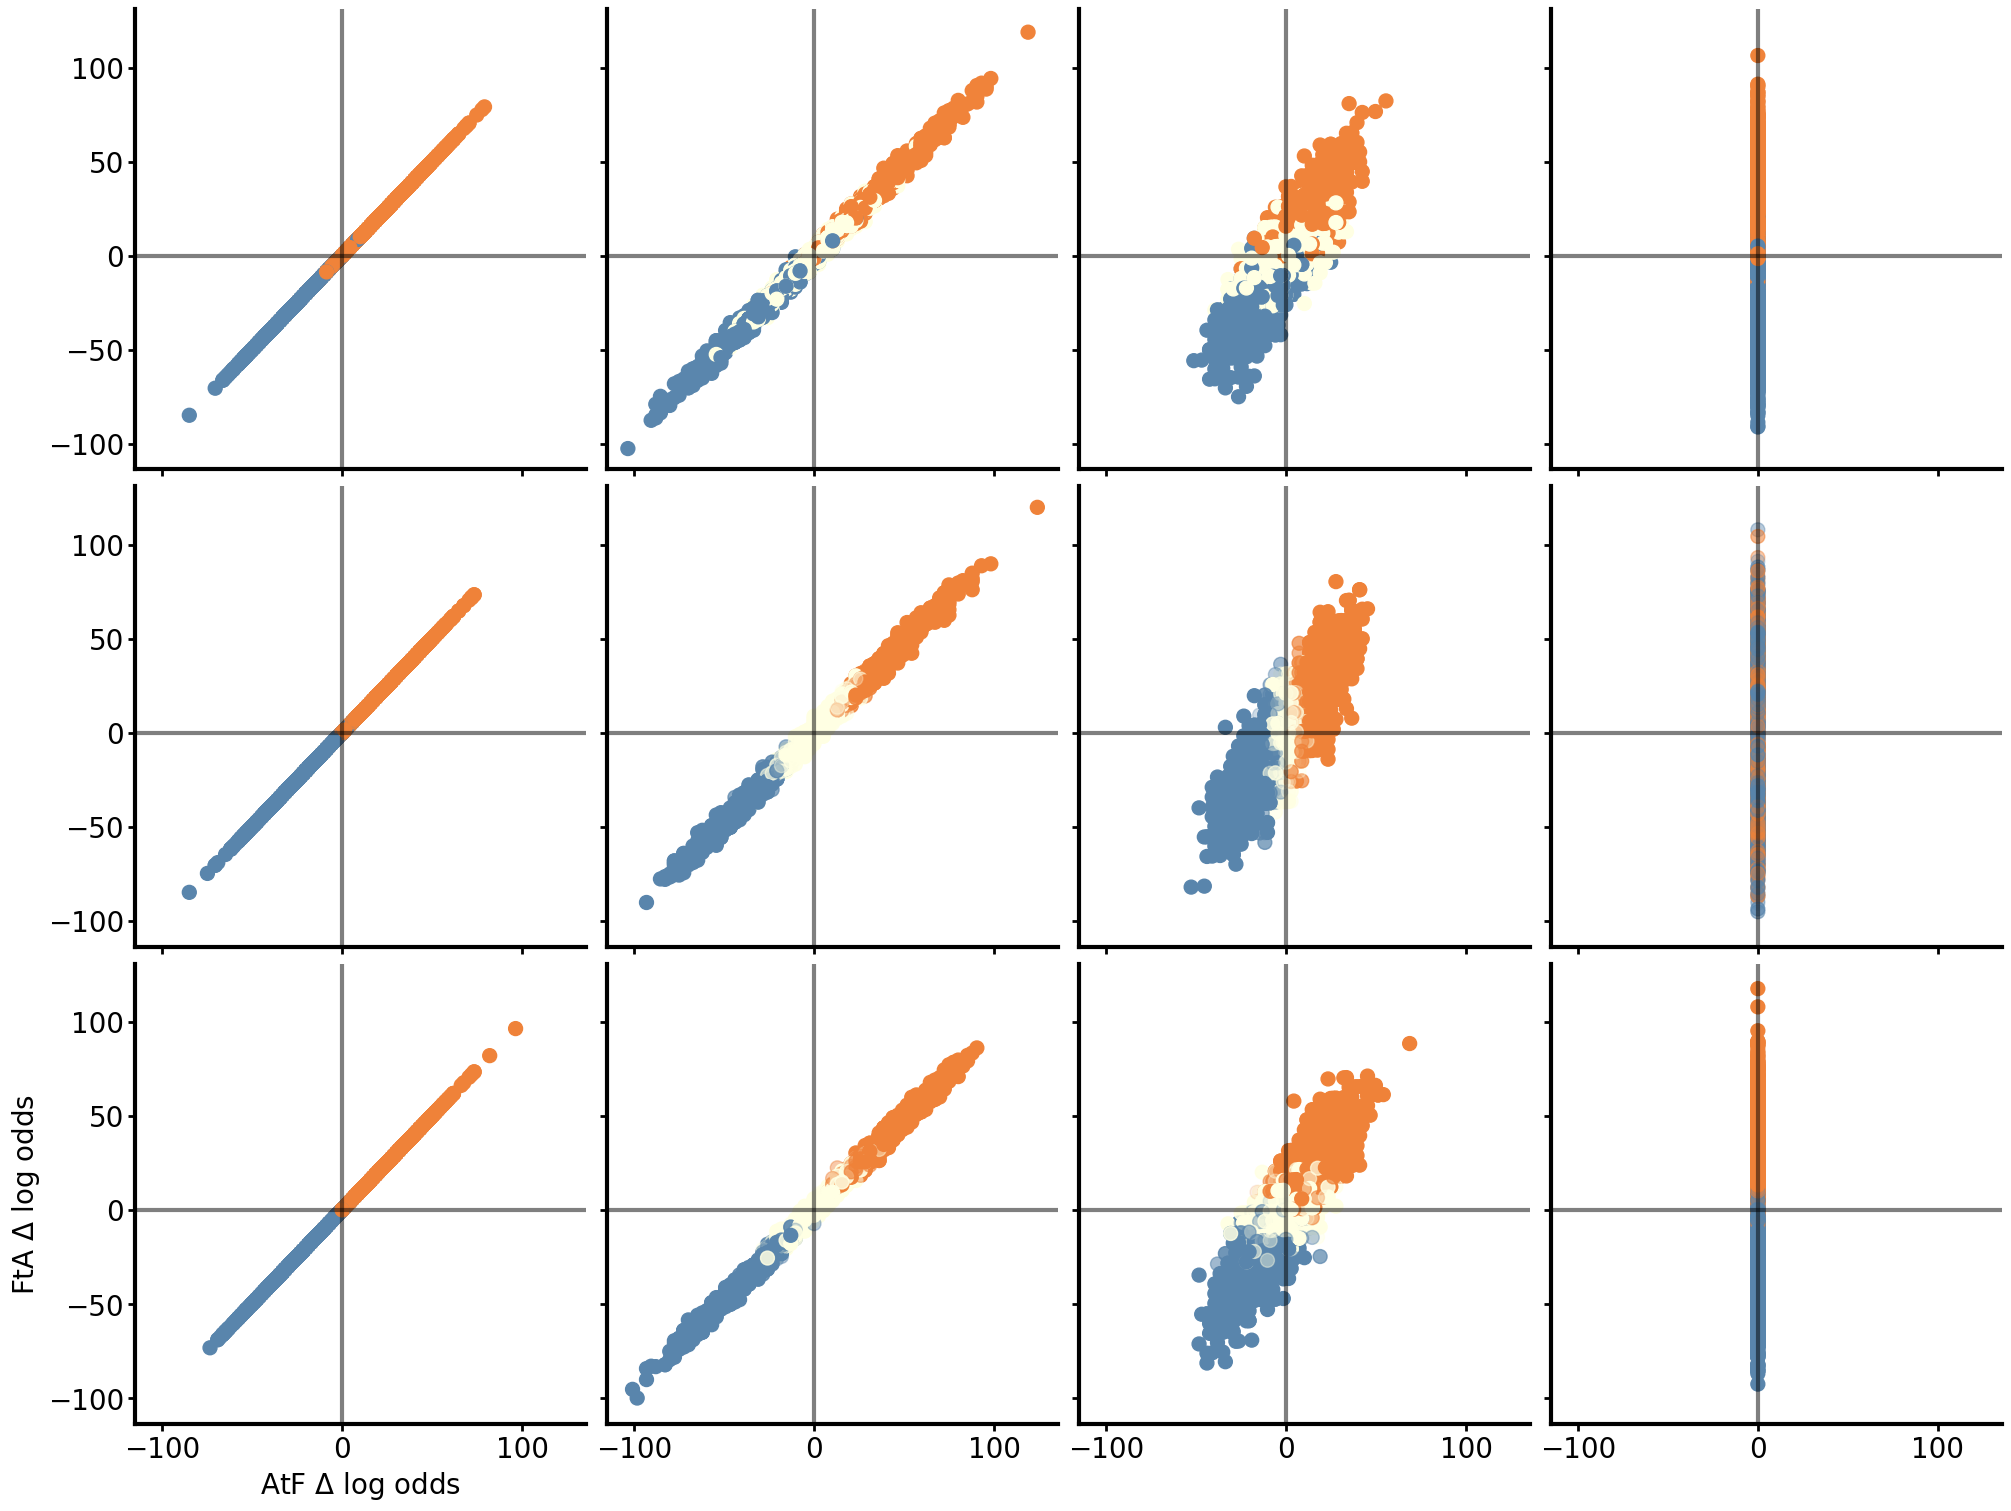

In [4]:
fig, axs = plt.subplots(
    3,
    len(tasks),
    figsize=(5 * len(tasks), 15),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

for b, task_prior in enumerate(tasks):
    
    # Labels
    plt.sca(axs[0, b])
    data = filter_data(SNN_data, {'origin': 'Test', 'arch_type':0, 'data_gen_type': intr_tasks[b]})
    rand_v = np.random.choice(data['directions'].values[0].shape[0], size=2000, replace=False)
    coords = log_odds_coords(task_prior, data['directions'].values[0][rand_v])
    plt.scatter(
        coords[0], coords[1], c=data['labels'].values[0][rand_v], cmap=cmap,
    )

    # SNNs
    for a, intr_arch in enumerate(intr_archs):
        plt.sca(axs[a+1, b])
        data = filter_data(SNN_data, {'origin': 'Test', 'arch_type':intr_arch, 'data_gen_type': intr_tasks[b]})
        rand_v = np.random.choice(data['directions'].values[0].shape[0], size=2000, replace=False)
        coords = log_odds_coords(task_prior, data['directions'].values[0][rand_v])
        cmap_mode = mode_cols(data['decisions'].values[0][:, rand_v], cmap_values)
        plt.scatter(coords[0], coords[1], c=cmap_mode)

    if b == 0:
        plt.xlabel(r"AtF $\Delta$ log odds")
        plt.ylabel(r"FtA $\Delta$ log odds")

for ax in axs.reshape(-1):
    ax.axhline(0, ls="-", c="k", alpha=0.5)
    ax.axvline(0, ls="-", c="k", alpha=0.5)

plt.savefig("Task_Space_Optimal.svg")